# Projet DA WildFires - Modélisation d'une prédiction de feu au niveau d'un état
__________________________________________________________________

> Par C. FONTAINE

## 0- Objectif de ce notebook

Dans ce notebook, nous allons travailler à une modélisation permettant de prédire l'occurence d'un feu au  niveau d'un état à partir de données météo.

In [97]:
import pandas as pd
import os
import numpy as np
from datetime import datetime
from sklearn.ensemble import HistGradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import ensemble
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, f1_score
import matplotlib.pyplot as plt
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import joblib

## 1 - Filtering data from other country

In [3]:
start = datetime.now()
for year in np.arange(1996,2016):
    listoffiles = os.listdir(f'{year}') #get de files in folder
    for file in listoffiles:
        state = pd.read_csv(f'{year}/{file}')['NAME'][0] #get the station name
        if pd.isna(state): #check if ther is a name
            os.remove(f"{year}/{file}")
        else:
            if state[-2:] != 'US': #get the country code in the name and check
                os.remove(f"{year}/{file}")
end = datetime.now()
elapsed = end-start
print(elapsed)

FileNotFoundError: [Errno 2] No such file or directory: '1996'

## 2 - The big merge

In [ ]:
start = datetime.now()

for year in np.arange(1992,2016):
    listoffiles = os.listdir(f'{year}') #get the files in folder
    yearstation = open(f'{year}/{year}.csv', 'a') #create the merge file for the year
    for line in open(f'{year}/{listoffiles[0]}', 'r'): #go through every line in the file
        yearstation.write(line) #write each line in the merge file
    for file in listoffiles[1:]: #go through each file in the directory
        station = open(f'{year}/{file}', 'r') #open the file
        next(station) #skip header
        for line in station: #go through every line in the file
            yearstation.write(line) #write each line in the merge file
        station.close()
    yearstation.close()

fullmerge = open('the_merge.csv', 'a') #create the merge file for the year
for line in open('1992/1992.csv', 'r'): #go through every line in the file
    fullmerge.write(line) #write each line in the merge file
for year in np.arange(1993,2016):
    current_year = open(f'{year}/{year}.csv', 'r') #open the file
    next(current_year) #skip header
    for line in current_year: #go through every line in the file
        fullmerge.write(line) #write each line in the merge file
    current_year.close()
fullmerge.close()

end = datetime.now()
elapsed = end-start
print(elapsed)

0:01:58.528257


## 3 - Importing the datas
### A - NOA Datas

In [3]:
df = pd.read_csv("the_merge.csv") # importing data from the merge
df.sample(10)

/tmp/ipykernel_164561/4042125064.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("the_merge.csv")


,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,TEMP,TEMP_ATTRIBUTES,DEWP,DEWP_ATTRIBUTES,...,MXSPD,GUST,MAX,MAX_ATTRIBUTES,MIN,MIN_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNDP,FRSHTT
15739372,74768853858,2015-03-12,30.46361,-88.53194,5.5,"PASCAGOULA LOTT INTERNATIONAL AIRPORT, MS US",68.5,24,66.9,24,...,12.0,20.0,72.0,*,66.2,*,0.17,G,999.9,10000
5964365,72256399999,2004-04-14,31.48300,-97.31700,180.0,"MC GREGOR EXECUTIVE, TX US",53.3,24,41.8,24,...,11.1,14.0,71.6,*,35.6,*,0.00,G,999.9,0
3707572,72231599999,2000-06-19,30.03300,-90.01700,2.0,"LAKEFRONT, LA US",82.9,24,75.5,24,...,18.1,22.9,89.6,*,78.8,*,0.01,B,999.9,10010
4772590,72257699999,2002-12-05,31.06700,-97.83300,309.0,"ROBERT GRAY ARMY AIR FIELD, TX US",38.0,24,30.1,24,...,15.9,18.1,48.2,*,33.8,*,0.04,G,999.9,0
12494034,72334703809,2012-06-02,36.00020,-89.40940,91.4,"DYERSBURG MUNICIPAL AIRPORT, TN US",74.2,9,51.8,9,...,12.0,18.1,78.8,*,64.4,*,0.00,G,999.9,0
5510578,72467699999,2003-05-21,39.22300,-106.86900,2384.0,"ASPEN PITKIN CO SARD, CO US",51.6,24,24.1,24,...,14.0,21.0,68.0,,30.9,,0.01,G,999.9,0
13898513,99770199999,2013-03-25,27.63000,-82.57000,3.0,"PORT MANATEE, FL US",65.2,24,9999.9,0,...,999.9,999.9,72.5,*,60.3,*,0.00,I,999.9,0
99424,72274799999,1992-12-30,32.85000,-109.63300,968.0,"SAFFORD REGIONAL, AZ US",53.3,24,50.1,24,...,4.9,999.9,59.0,*,46.9,*,0.00,I,999.9,0
15320327,72286893138,2015-01-08,33.82220,-116.50430,124.7,"PALM SPRINGS ASOS, CA US",64.8,24,37.2,24,...,8.0,999.9,84.0,,50.0,,0.00,G,999.9,0
7833306,99999954796,2006-03-01,41.49110,-71.54130,35.1,"KINGSTON 1 NW, RI US",26.1,24,9999.9,0,...,999.9,999.9,34.5,,19.0,,0.00,G,999.9,0


FIELD            DESCRIPTION

STATION - Station number (WMO/DATSAV3 possibly combined w/WBAN number) 

DATE - Given in mm/dd/yyyy format

LATITUDE - Given in decimated degrees (Southern Hemisphere values are negative)

LONGITUDE - Given in decimated degrees (Western Hemisphere values are negative)

ELEVATION - Given in meters

NAME - Name of station/airport/military base

TEMP - Mean temperature for the day in degrees Fahrenheit to tenths. Missing = 9999.9

TEMP_ATTRIBUTES - Number of observations used in calculating mean temperature.

DEWP - Mean dew point for the day in degrees Fahrenheit to tenths. Missing = 9999.9

DEWP_ATTRIBUTES - Number of observations used in calculating mean dew point.  

SLP - Mean sea level pressure for the day in millibars to tenths. Missing = 9999.9

SLP_ATTRIBUTES - Number of observations used in calculating mean sea level pressure.

STP - Mean station pressure for the day in millibars to tenths. Missing = 9999.9

STP_ATTRIBUTES - Number of observations used in calculating mean station pressure.  

VISIB - Mean visibility for the day in miles to tenths. Missing = 999.9

VISIB_ATTRIBUTES - Number of observations used in calculating mean visibility.      

WDSP - Mean wind speed for the day in knots to tenths.  Missing = 999.9 

WDSP_ATTRIBUTES - Number of observations used in calculating mean wind speed.

MXSPD - Maximum sustained wind speed reported for the day in knots to tenths. Missing = 
999.9

GUST - Maximum wind gust reported for the day in knots to tenths.  Missing = 999.9

MAX - Maximum temperature reported during the day in Fahrenheit to tenths. Missing = 9999.9


In [4]:
column2drop = ['TEMP_ATTRIBUTES', 'DEWP_ATTRIBUTES', 'SLP_ATTRIBUTES', 'STP_ATTRIBUTES', 'VISIB_ATTRIBUTES', 'WDSP_ATTRIBUTES']
df.drop(column2drop, axis = 1, inplace=True) #droping non relevant data for the merge

In [5]:
# setting the missing data to nan
df.loc[df['TEMP'] == 9999.9, 'TEMP'] = np.nan
df.loc[df['DEWP'] == 9999.9, 'DEWP'] = np.nan
df.loc[df['SLP'] == 9999.9, 'SLP'] = np.nan
df.loc[df['STP'] == 9999.9, 'STP'] = np.nan
df.loc[df['VISIB'] == 999.9, 'VISIB'] = np.nan
df.loc[df['WDSP'] == 999.9, 'WDSP'] = np.nan
df.loc[df['MXSPD'] == 999.9, 'MXSPD'] = np.nan
df.loc[df['GUST'] == 999.9, 'GUST'] = np.nan
df.loc[df['MAX'] == 9999.9, 'MAX'] = np.nan

### B - The fire prédiction model

In [6]:
df_fire = pd.read_csv('fires.csv') #importing fire data
df_fire

/tmp/ipykernel_164561/3696251853.py:1: DtypeWarning: Columns (8,10,11,12,13,14,15,16,17,18,35,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df_fire = pd.read_csv('fires.csv')


,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63.0,63.0,Plumas,AAGtEAAA6GTCkl9AXsDgyGyYugREQOhkwpJfQF7A4MhsmL...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61.0,61.0,Placer,AAGtEAAAVLbuauIZXsCQxlVdbndDQFS27mriGV7AkMZVXW...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17.0,17.0,El Dorado,AAGtEAAA0KWgVxMvXsBQu2Ys+X1DQNCloFcTL17AULtmLP...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3.0,3.0,Alpine,AAGtEAAAlKyjDXT6XcDoVADGkkdDQJSsow10+l3A6FQAxp...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3.0,3.0,Alpine,AAGtEAAAQOOqLrf7XcDoVADGkkdDQEDjqi63+13A6FQAxp...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880460,1880461,300348363,2015CAIRS29019636,NONFED,ST-CACDF,ST/C&L,USCASHU,Shasta-Trinity Unit,CASHU,Shasta-Trinity Unit,...,A,40.481637,-122.389375,13.0,STATE OR PRIVATE,CA,NaN,NaN,NaN,AAGtEAAAULgeheuYXsCYxf1Hpj1EQFC4HoXrmF7AmMX9R6...
1880461,1880462,300348373,2015CAIRS29217935,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,Tuolumne-Calaveras Unit,...,A,37.617619,-120.938570,12.0,MUNICIPAL/LOCAL,CA,NaN,NaN,NaN,AAGtEAAAAIC+iBE8XsCoygYlDs9CQACAvogRPF7AqMoGJQ...
1880462,1880463,300348375,2015CAIRS28364460,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,Tuolumne-Calaveras Unit,...,A,37.617619,-120.938570,12.0,MUNICIPAL/LOCAL,CA,NaN,NaN,NaN,AAGtEAAAAIC+iBE8XsCoygYlDs9CQACAvogRPF7AqMoGJQ...
1880463,1880464,300348377,2015CAIRS29218079,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,Tuolumne-Calaveras Unit,...,B,37.672235,-120.898356,12.0,MUNICIPAL/LOCAL,CA,NaN,NaN,NaN,AAGtEAAAeLpfqn45XsC4ZEzJC9ZCQHi6X6p+OV7AuGRMyQ...


In [7]:
#cleaning data
type = {"FIRE_CODE" : "str", "FIRE_NAME" : "str", "STATE" : "str"} #mixed type management
df_fire = df_fire.astype(type)

# deletion on unrelevent column
df_fire = df_fire.drop(['OBJECTID',
                        'FOD_ID', 
                        'FPA_ID', 
                        'SOURCE_SYSTEM_TYPE', 
                        'SOURCE_SYSTEM',
                        'NWCG_REPORTING_AGENCY', 
                        'NWCG_REPORTING_UNIT_ID',
                        'NWCG_REPORTING_UNIT_NAME', 
                        'SOURCE_REPORTING_UNIT',
                        'SOURCE_REPORTING_UNIT_NAME', 
                        'LOCAL_FIRE_REPORT_ID',
                        'LOCAL_INCIDENT_ID', 
                        'FIRE_CODE', 
                        'FIRE_NAME',
                        'ICS_209_INCIDENT_NUMBER', 
                        'ICS_209_NAME', 
                        'MTBS_ID', 
                        'MTBS_FIRE_NAME',
                        'COMPLEX_NAME', 
                        'FIRE_YEAR', 
                        'DISCOVERY_DOY',
                        'DISCOVERY_TIME', 
                        'STAT_CAUSE_CODE', 
                        'STAT_CAUSE_DESCR', 
                        'CONT_DATE',
                        'CONT_DOY', 
                        'CONT_TIME', 
                        'FIRE_SIZE', 
                        'FIRE_SIZE_CLASS', 
                        'LATITUDE',
                        'LONGITUDE', 
                        'OWNER_CODE', 
                        'OWNER_DESCR', 
                        'COUNTY',
                        'FIPS_CODE', 
                        'FIPS_NAME', 
                        'Shape'], axis=1)

df_fire['DISCOVERY_DATE'] = pd.to_datetime(df_fire['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D') #date formating

### C - Compiling datas

In [8]:
df['STATE'] = df['NAME'].apply(lambda x : x[-5:-3]) #getting the state 

In [9]:
list_true_false = [',' in entry for entry in df['STATE']] #list to get rid of station that's are not within the ordinary boundary of a state (ie : marine station or remote islands)

df.drop(index=df.loc[list_true_false].index, inplace=True)

In [17]:
df_state = df.groupby(by = ['STATE', 'DATE']).mean() #groupingby the meteo data
df_fire['fire'] = 1
df_fire.rename(columns={'DISCOVERY_DATE' : 'DATE'}, inplace=True) #groupingby the fire
df_fire_grouped = df_fire.groupby(by = ['STATE', 'DATE']).mean()

In [23]:
df_combined = df_state.merge(right = df_fire_grouped, right_index=True, left_index=True, how='left') #last merge on their index

In [26]:
df_combined['fire'] = df_combined['fire'].fillna(0) #geting ride of nan (no fire = 0)

In [31]:
df_combined['fire'] = df_combined['fire'].astype(int) #setting it to int
df_combined.to_csv('combined-data.csv') #export for the team

# 4 - Model building


## 4.1 - Reduction with ACP

Anticipating that model generation could be important I decided to see what can be achieved with basic reduction.

In [66]:
df = pd.read_csv('combined-data.csv')
df_ACP = df.dropna()

In [5]:
def the_acp_reductionner(df_ACP):
    scaler = StandardScaler()
    target = df_ACP['fire']
    pca = PCA()
    df_norm = scaler.fit_transform(df_ACP)
    Coord = pca.fit_transform(df_norm)

    return (pca, Coord, target)

pca_AK, coord_AK, target_AK = the_acp_reductionner(df.loc[df['STATE'] == 'AK'].drop(['STATE', 'DATE', 'LONGITUDE', 'LATITUDE'], axis=1).dropna())


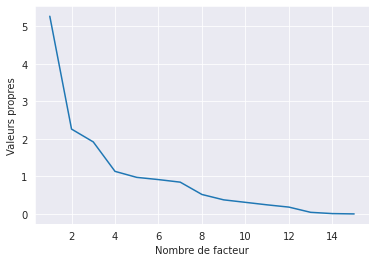

In [6]:
plt.plot(np.arange(1, 16), pca_AK.explained_variance_)
plt.xlabel('Nombre de facteur')
plt.ylabel('Valeurs propres');

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


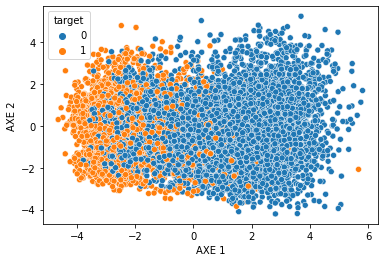

In [32]:
PCA_mat = pd.DataFrame({'AXE 1': coord_AK[:, 0], 'AXE 2': coord_AK[:, 1], 'target': target_AK})
sns.scatterplot('AXE 1', 'AXE 2', hue='target', data=PCA_mat);

ACP may be not useful taking into account that there are only only 13 variables and a big chunk of information have been lost.

## 4.2 Finding the right model
We chose to explore the random forest which seams to fit our needs here.

In [69]:
# Sampling
df_RFC = df.dropna()
target = df_RFC.loc[df['STATE'] == 'AK', 'fire']
data_AK = df_RFC.loc[df['STATE'] == 'AK'].drop(['STATE', 'DATE', 'LONGITUDE', 'LATITUDE', 'fire'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(data_AK, target, test_size=0.2, random_state=66)

In [ ]:
# Building the hyperparameter tuning
RFC = ensemble.RandomForestClassifier()
params = {'bootstrap': [True, False],
          'max_depth': [20, 40, 60, 80, 100, None],
          'min_samples_leaf': [1, 2, 4, 10, 20, 40],
          'min_samples_split': [2, 5, 10],
          'n_estimators': [100, 200, 400, 600, 800, 1000]}
gridcv = GridSearchCV(RFC, param_grid=params, scoring='accuracy', cv=3, n_jobs=8)

gridcv.fit(X_train, y_train)
result = pd.DataFrame(gridcv.cv_results_)[['params', 'mean_test_score', 'std_test_score']]
result.to_csv('RFC_result.csv') #exporting because of IDE crash
result

Les meilleurs paramètres sont donc : {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

In [72]:
RFC = ensemble.RandomForestClassifier(random_state=321, min_samples_leaf=2, bootstrap=True) #testing the parameters
RFC.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=2, random_state=321)

In [73]:
y_pred = RFC.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,960,152
1,131,510


In [74]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1112
           1       0.77      0.80      0.78       641

    accuracy                           0.84      1753
   macro avg       0.83      0.83      0.83      1753
weighted avg       0.84      0.84      0.84      1753



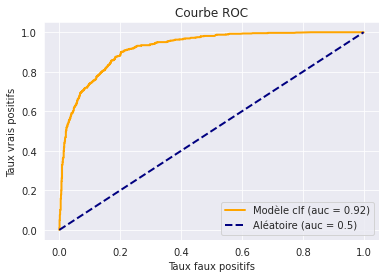

In [77]:
probs = RFC.predict_proba(X_test)
fpr, tpr, seuils = roc_curve(y_test, probs[:,1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='orange', lw=2, label='Modèle clf (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show();

The accuracy is not very convincing for the prevention purposes, is high enough to get interesting statistics about feature importance.

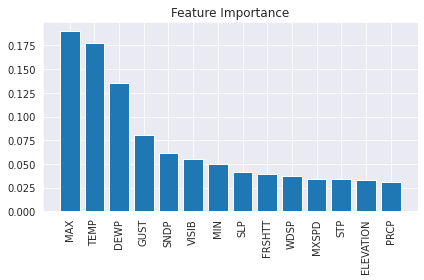

In [111]:
importances = RFC.feature_importances_
# Sort the feature importance in descending order
sorted_indices = np.argsort(importances)[::-1]

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

Clearly Max temperature, average temperature and dewpoint are the most important feature. The wind play a probably biger part for the size of the fire.

We can test if balanced datas could improve the result

In [ ]:
BRFC = BalancedRandomForestClassifier()
params = {'bootstrap': [True, False],
          'max_depth': [20, 40, 60, 80, 100, None],
          'min_samples_leaf': [1, 2, 4],
          'min_samples_split': [2, 5, 10],
          'n_estimators': [100, 200, 400, 600, 800, 1000]}
gridcv = GridSearchCV(BRFC, param_grid=params, scoring='accuracy', cv=3, n_jobs=8)

gridcv.fit(X_train, y_train)
result = pd.DataFrame(gridcv.cv_results_)[['params', 'mean_test_score', 'std_test_score']]
result.to_csv('imbl_result.csv')

The result are even less accurate. We need to check other algorithm.

In [59]:
KNC = KNeighborsClassifier(n_jobs=8)
params = {'n_neighbors' : [5, 8, 10, 15, 20],
          'weights' : ['uniform', 'distance'],
          'algorithm' : ['ball_tree', 'kd_tree'],
          'leaf_size' : [10, 20, 30, 40, 50]}

gridcv = GridSearchCV(KNC, param_grid=params, scoring='accuracy', cv=3, n_jobs=8)

gridcv.fit(X_train, y_train)
result = pd.DataFrame(gridcv.cv_results_)[['params', 'mean_test_score', 'std_test_score']]
result.to_csv('KNC_result.csv')

Not much more convincing, We have better result with boosting algorythm. We can check the histgradienboosting which support nan natively.

In [80]:
df = pd.read_csv('combined-data.csv')
target = df.loc[df['STATE'] == 'AK', 'fire']
data_AK = df.loc[df['STATE'] == 'AK'].drop(['STATE', 'DATE', 'LONGITUDE', 'LATITUDE', 'fire'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(data_AK, target, test_size=0.2, random_state=66)

In [ ]:
HGBC = HistGradientBoostingClassifier()
params = {'max_leaf_nodes': [20, 31, 40, 50],
          'max_depth': [20, 40, 60, 80, 100, None],
          'min_samples_leaf': [10, 20, 40]}

gridcv = GridSearchCV(HGBC, param_grid=params, scoring='accuracy', cv=3, n_jobs=8)

gridcv.fit(X_train, y_train)
result = pd.DataFrame(gridcv.cv_results_)[['params', 'mean_test_score', 'std_test_score']]
result.to_csv('HGBC_result.csv')
result

In [81]:
HGBC = HistGradientBoostingClassifier(max_depth=20, max_leaf_nodes=20, min_samples_leaf=40)
HGBC.fit(X_train, y_train)

HistGradientBoostingClassifier(max_depth=20, max_leaf_nodes=20,
                               min_samples_leaf=40)

In [82]:
y_pred = RFC.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,1007,95
1,76,576


In [83]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1102
           1       0.86      0.88      0.87       652

    accuracy                           0.90      1754
   macro avg       0.89      0.90      0.90      1754
weighted avg       0.90      0.90      0.90      1754



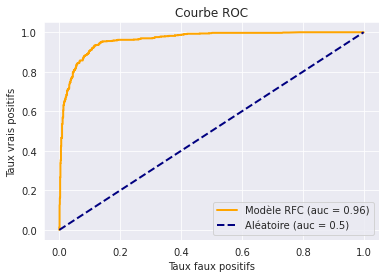

In [85]:
probs = RFC.predict_proba(X_test)
fpr, tpr, seuils = roc_curve(y_test, probs[:,1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='orange', lw=2, label='Modèle RFC (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show();

We have here much better result thanks to the incorporation of line with missing values.

## 4.3 - Creating models for all states

In [ ]:
df = pd.read_csv('combined-data.csv') #getting the unaltered data
state_list = df['STATE'].unique()

test_result = {}

#for each state, build a model, and store it.
for state in state_list:
    target = df.loc[df['STATE'] == state, 'fire']
    data = df.loc[df['STATE'] == state].drop(['STATE', 'DATE', 'LONGITUDE', 'LATITUDE', 'fire'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

    HGBC = HistGradientBoostingClassifier(max_depth=20, max_leaf_nodes=20, min_samples_leaf=40)
    HGBC.fit(X_train, y_train)
    y_pred = HGBC.predict(X_test)

    #storing the model performance for each state
    test_result[state] = f1_score(y_test, y_pred)

    # save
    joblib.dump(HGBC, f"model_{state}.pkl")


In [118]:
Model_performance = pd.DataFrame(test_result, index=['f1_score']).T
Model_performance.sort_values(by='f1_score', ascending=False)

,f1_score
CA,0.975882
FL,0.959330
GA,0.958308
AZ,0.927896
NC,0.920882
TX,0.918883
SC,0.913639
NY,0.895753
MS,0.889130
NM,0.884195


Interestingly enough there is a huge discrepancy between the result of the states that could be worth investigating.